In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pywt
import numpy as np
from skimage.util import view_as_windows
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [ ]:
df = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images',
                                            image_size=(256,256),
                                            batch_size=32, label_mode='int', shuffle=True)

Found 1846 files belonging to 30 classes.


In [ ]:
class_names = np.array(df.class_names)
print(class_names)

['Alpinia Galanga (Rasna)' 'Amaranthus Viridis (Arive-Dantu)'
 'Artocarpus Heterophyllus (Jackfruit)' 'Azadirachta Indica (Neem)'
 'Basella Alba (Basale)' 'Brassica Juncea (Indian Mustard)'
 'Carissa Carandas (Karanda)' 'Citrus Limon (Lemon)'
 'Ficus Auriculata (Roxburgh fig)' 'Ficus Religiosa (Peepal Tree)'
 'Hibiscus Rosa-sinensis' 'Jasminum (Jasmine)' 'Mangifera Indica (Mango)'
 'Mentha (Mint)' 'Moringa Oleifera (Drumstick)'
 'Muntingia Calabura (Jamaica Cherry-Gasagase)' 'Murraya Koenigii (Curry)'
 'Nerium Oleander (Oleander)' 'Nyctanthes Arbor-tristis (Parijata)'
 'Ocimum Tenuiflorum (Tulsi)' 'Piper Betle (Betel)'
 'Plectranthus Amboinicus (Mexican Mint)'
 'Pongamia Pinnata (Indian Beech)' 'Psidium Guajava (Guava)'
 'Punica Granatum (Pomegranate)' 'Santalum Album (Sandalwood)'
 'Syzygium Cumini (Jamun)' 'Syzygium Jambos (Rose Apple)'
 'Tabernaemontana Divaricata (Crape Jasmine)'
 'Trigonella Foenum-graecum (Fenugreek)']


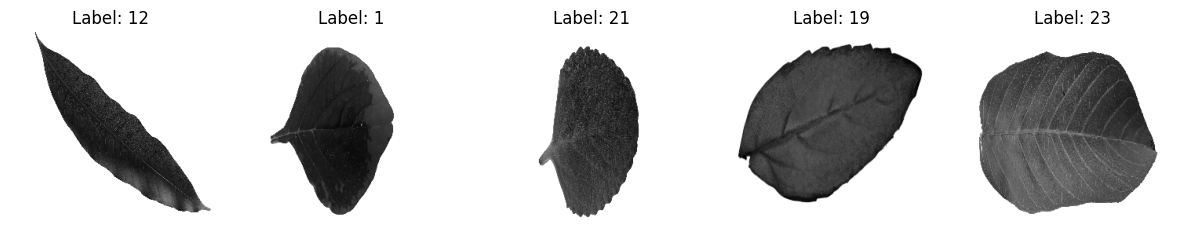

In [ ]:
def visualize_images(X, y, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(X[i], cmap='gray')
        ax.set_title(f'Label: {y[i]}')
        ax.axis('off')
    plt.show()

for batch_images, batch_labels in df.take(1):
    grayscale_images = [tf.image.rgb_to_grayscale(img).numpy().squeeze() for img in batch_images]
    visualize_images(grayscale_images[:5], batch_labels.numpy()[:5])

In [ ]:
def preprocess_image(image):
    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)
    image = tf.squeeze(image, axis=-1)
    coeffs2 = pywt.dwt2(image.numpy(), 'haar')
    cA, (cH, cV, cD) = coeffs2
    return cA

In [ ]:
X, y = [], []
for batch_images, batch_labels in df:
    for image, label in zip(batch_images, batch_labels):
        label = label.numpy()
        processed_image = preprocess_image(image)
        X.append(processed_image.flatten())
        y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
X[:5]

array([[509.949, 509.949, 509.949, ..., 509.949, 509.949, 509.949],
       [509.949, 509.949, 509.949, ..., 509.949, 509.949, 509.949],
       [509.949, 509.949, 509.949, ..., 509.949, 509.949, 509.949],
       [509.949, 509.949, 509.949, ..., 509.949, 509.949, 509.949],
       [509.949, 509.949, 509.949, ..., 509.949, 509.949, 509.949]],
      dtype=float32)

In [ ]:
y[:5]

array([20, 11,  7, 23, 25], dtype=int32)

In [ ]:
X.shape

(1846, 16384)

In [ ]:
y.shape

(1846,)

In [ ]:
pip install opencv-python

Original feature shape: (1846, 128)
Reduced feature shape: (1846, 34)
Accuracy (RandomForest): 0.68
Precision (Overall): 0.69
Recall (Overall): 0.68
F1-Score (Overall): 0.68
Confusion Matrix:


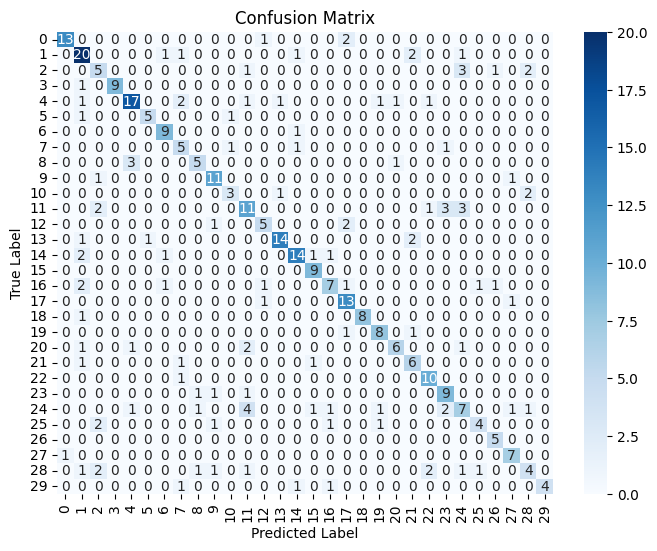

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = np.zeros((1, 128))
    return descriptors

X, y = [], []
for batch_images, batch_labels in df:
    for image, label in zip(batch_images, batch_labels):
        grayscale_image = tf.image.rgb_to_grayscale(image).numpy().astype('uint8').squeeze()
        descriptors = extract_sift_features(grayscale_image)
        sift_features = descriptors.mean(axis=0)
        X.append(sift_features)
        y.append(label.numpy())

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_normalized)

print(f"Original feature shape: {X.shape}")
print(f"Reduced feature shape: {X_pca.shape}")
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy (RandomForest): {accuracy_rf:.2f}")
print(f"Precision (Overall): {precision_rf:.2f}")
print(f"Recall (Overall): {recall_rf:.2f}")
print(f"F1-Score (Overall): {f1_rf:.2f}")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


KNN Accuracy: 0.62
KNN Precision (Overall): 0.63
KNN Recall (Overall): 0.63
KNN F1-Score (Overall): 0.61

KNN Classification Report:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.83      0.83      0.83        12
            Amaranthus Viridis (Arive-Dantu)       0.46      0.41      0.43        27
        Artocarpus Heterophyllus (Jackfruit)       0.53      0.56      0.55        16
                   Azadirachta Indica (Neem)       0.67      1.00      0.80         8
                       Basella Alba (Basale)       0.79      0.94      0.86        16
            Brassica Juncea (Indian Mustard)       0.80      0.80      0.80        10
                  Carissa Carandas (Karanda)       0.67      0.33      0.44        12
                        Citrus Limon (Lemon)       0.75      0.53      0.62        17
             Ficus Auriculata (Roxburgh fig)       0.00      0.00      0.00         5
      

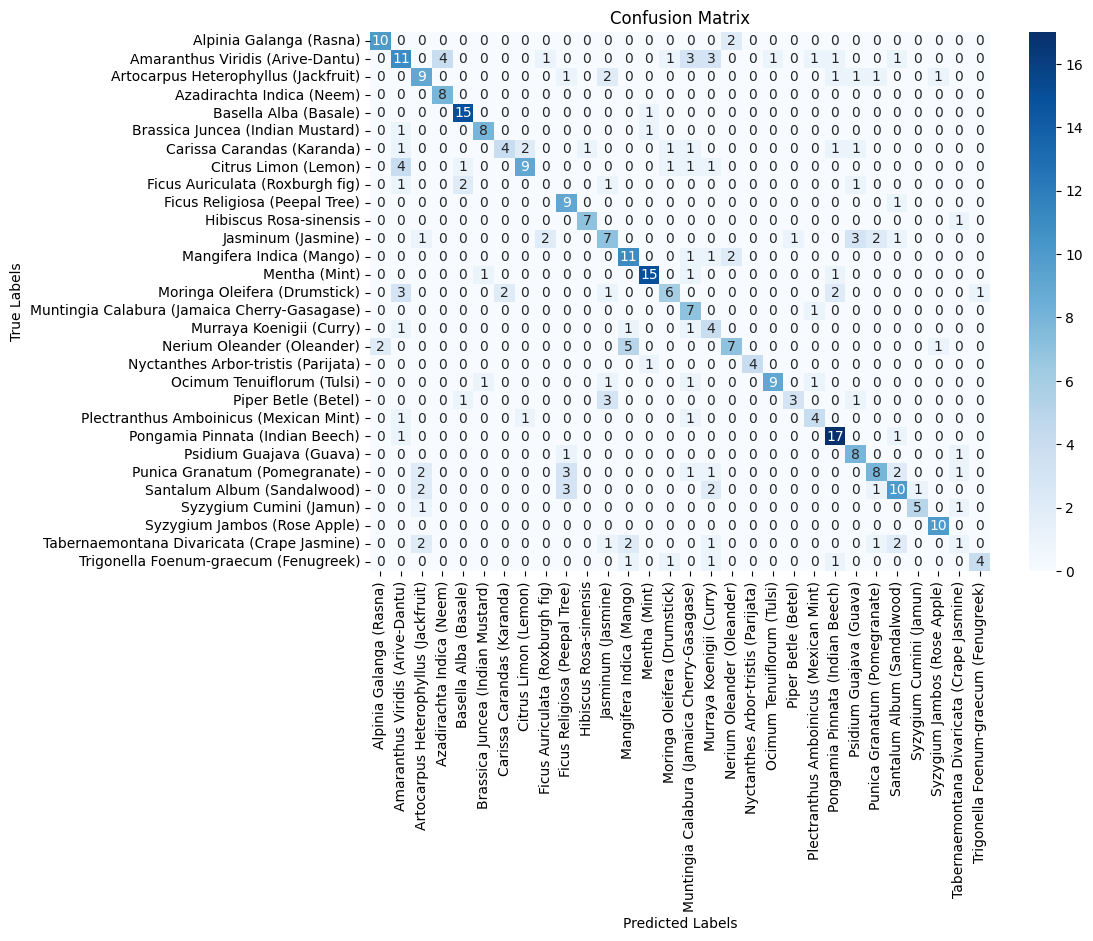

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import seaborn as sns
import matplotlib.pyplot as plt
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average="macro", zero_division=1)
recall_knn = recall_score(y_test, y_pred_knn, average="macro", zero_division=1)
f1_knn = f1_score(y_test, y_pred_knn, average="macro", zero_division=1)
print(f"KNN Accuracy: {accuracy_knn:.2f}")
print(f"KNN Precision (Overall): {precision_knn:.2f}")
print(f"KNN Recall (Overall): {recall_knn:.2f}")
print(f"KNN F1-Score (Overall): {f1_knn:.2f}")
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=class_names, zero_division=1))
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print("\nConfusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


SVM Accuracy: 0.70
SVM Precision (Overall): 0.70
SVM Recall (Overall): 0.70
SVM F1-Score (Overall): 0.69

SVM Classification Report:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.92      0.92      0.92        12
            Amaranthus Viridis (Arive-Dantu)       0.58      0.67      0.62        27
        Artocarpus Heterophyllus (Jackfruit)       0.80      0.50      0.62        16
                   Azadirachta Indica (Neem)       0.89      1.00      0.94         8
                       Basella Alba (Basale)       0.78      0.88      0.82        16
            Brassica Juncea (Indian Mustard)       0.80      0.80      0.80        10
                  Carissa Carandas (Karanda)       0.73      0.92      0.81        12
                        Citrus Limon (Lemon)       0.75      0.53      0.62        17
             Ficus Auriculata (Roxburgh fig)       0.00      0.00      0.00         5
      

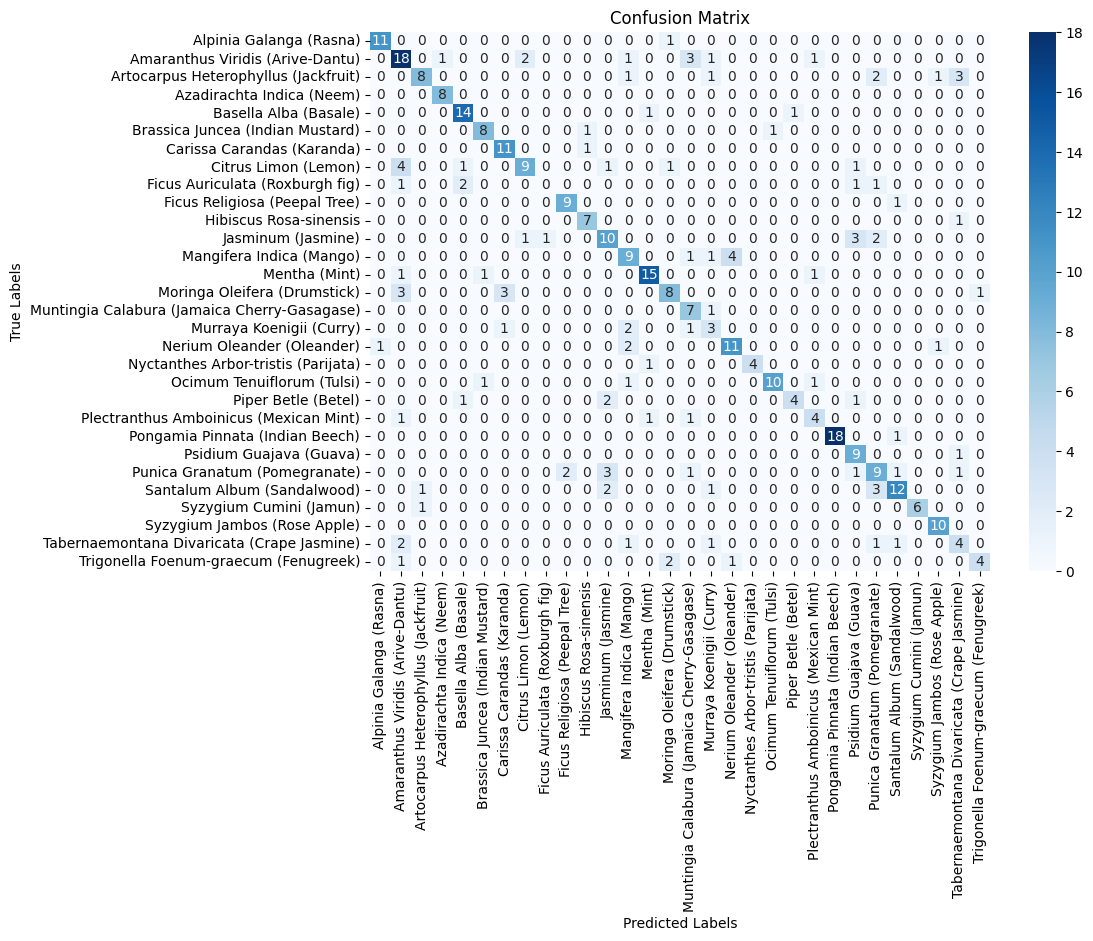

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='macro', zero_division=1)
recall_svm = recall_score(y_test, y_pred_svm, average='macro', zero_division=1)
f1_svm = f1_score(y_test, y_pred_svm, average='macro', zero_division=1)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(f"SVM Precision (Overall): {precision_svm:.2f}")
print(f"SVM Recall (Overall): {recall_svm:.2f}")
print(f"SVM F1-Score (Overall): {f1_svm:.2f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=class_names, zero_division=1))
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("\nConfusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Decision Tree Accuracy: 0.36
Precision (Overall): 0.38
Recall (Overall): 0.36
F1-Score (Overall): 0.36
Decision Tree Classification Report:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.92      1.00      0.96        12
            Amaranthus Viridis (Arive-Dantu)       0.24      0.33      0.28        27
        Artocarpus Heterophyllus (Jackfruit)       0.12      0.12      0.12        16
                   Azadirachta Indica (Neem)       0.33      0.50      0.40         8
                       Basella Alba (Basale)       0.61      0.88      0.72        16
            Brassica Juncea (Indian Mustard)       0.50      0.30      0.38        10
                  Carissa Carandas (Karanda)       0.00      0.00      0.00        12
                        Citrus Limon (Lemon)       0.11      0.06      0.08        17
             Ficus Auriculata (Roxburgh fig)       0.00      0.00      0.00         5

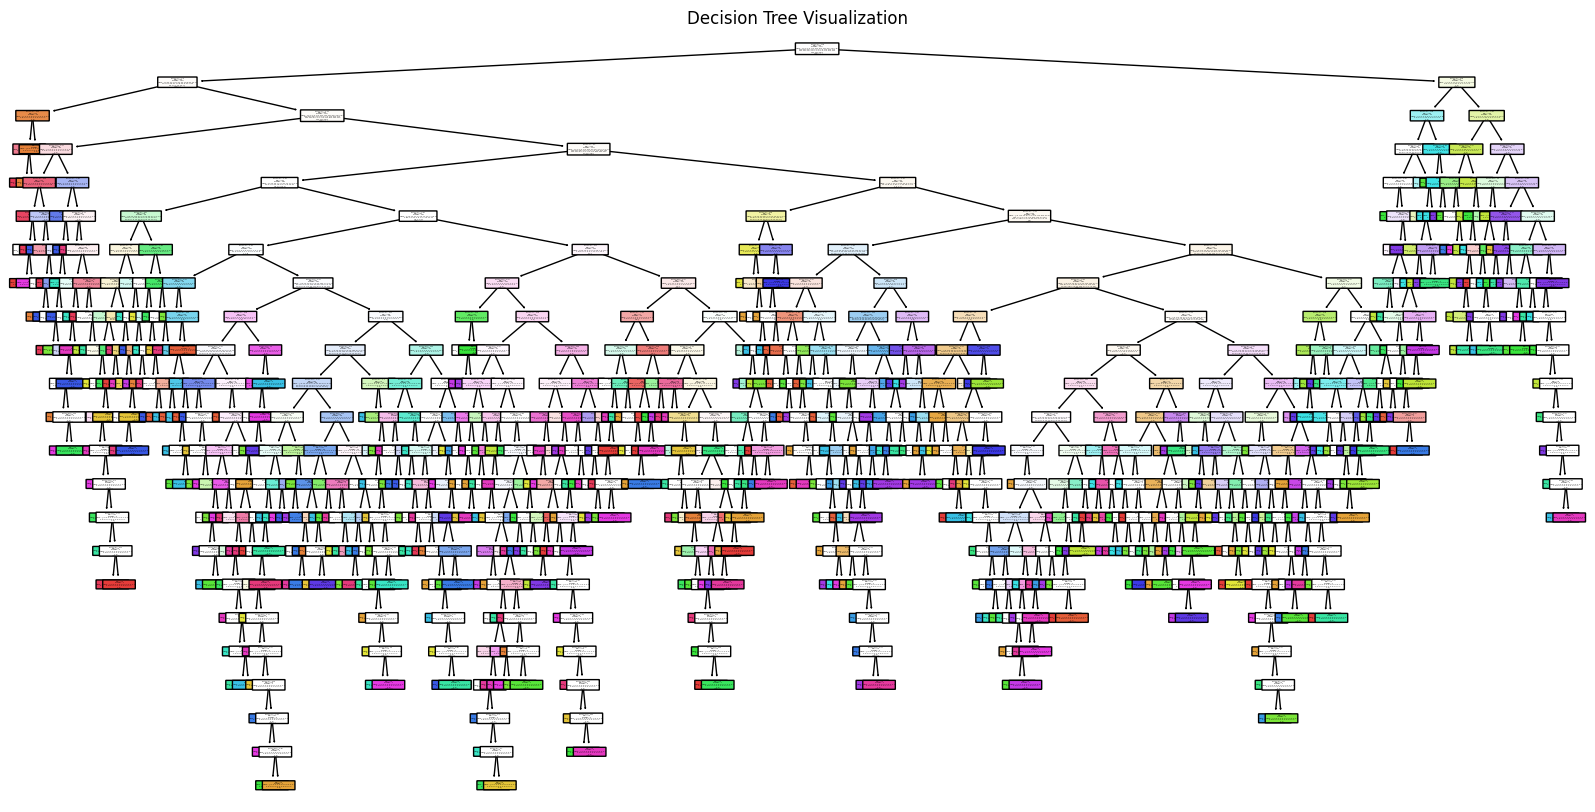

Confusion Matrix:


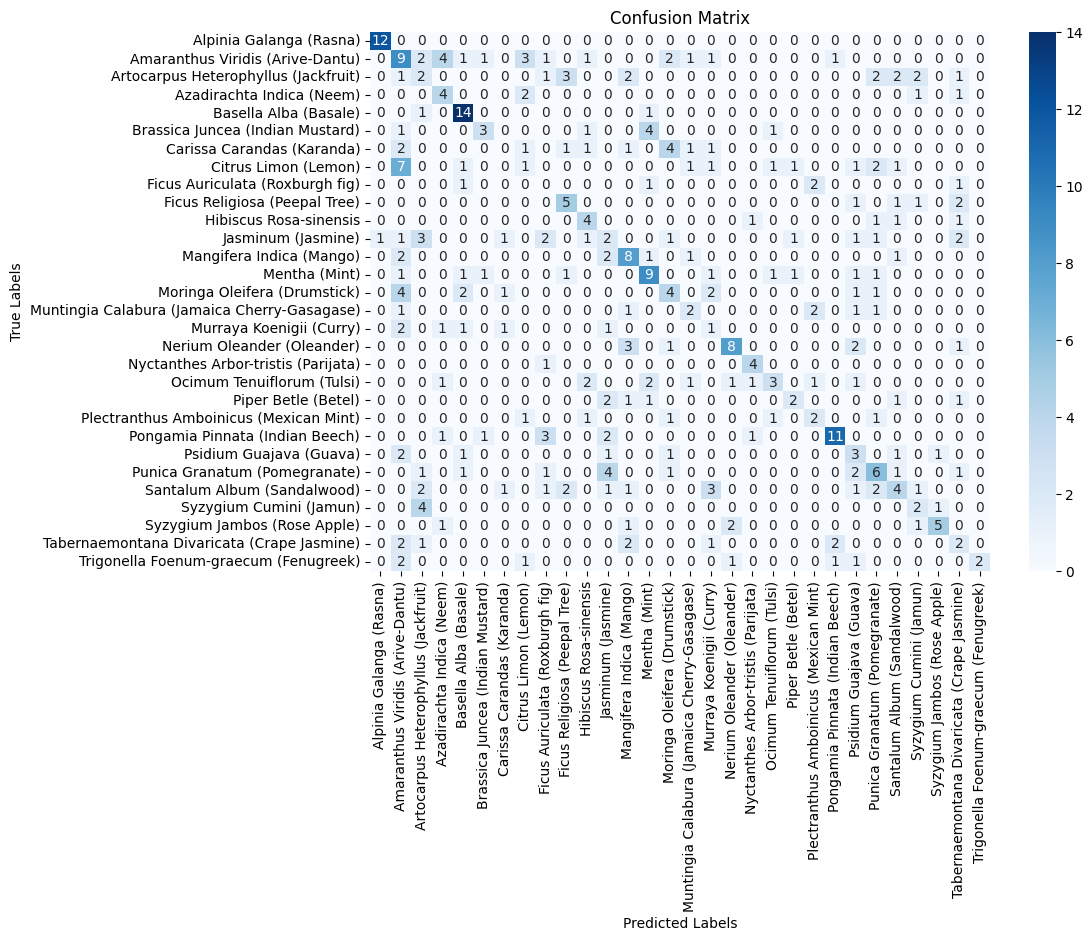

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")
print(f"Precision (Overall): {precision_dt:.2f}")
print(f"Recall (Overall): {recall_dt:.2f}")
print(f"F1-Score (Overall): {f1_dt:.2f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=class_names))
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=[f'Feature {i}' for i in range(X_train.shape[1])],
          class_names=[str(i) for i in np.unique(y)], rounded=True, proportion=False, precision=2)
plt.title('Decision Tree Visualization')
plt.show()
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")


Length of X: 1846
Length of y: 1846


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:10:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.80      1.00      0.89        12
            Amaranthus Viridis (Arive-Dantu)       0.55      0.59      0.57        27
        Artocarpus Heterophyllus (Jackfruit)       0.47      0.44      0.45        16
                   Azadirachta Indica (Neem)       1.00      1.00      1.00         8
                       Basella Alba (Basale)       0.82      0.88      0.85        16
            Brassica Juncea (Indian Mustard)       0.80      0.80      0.80        10
                  Carissa Carandas (Karanda)       0.78      0.58      0.67        12
                        Citrus Limon (Lemon)       0.67      0.59      0.62        17
             Ficus Auriculata (Roxburgh fig)       0.20      0.20      0.20         5
               Ficus Religiosa (Peepal Tree)       0.60      0.90      0.72        10
                      Hibiscus

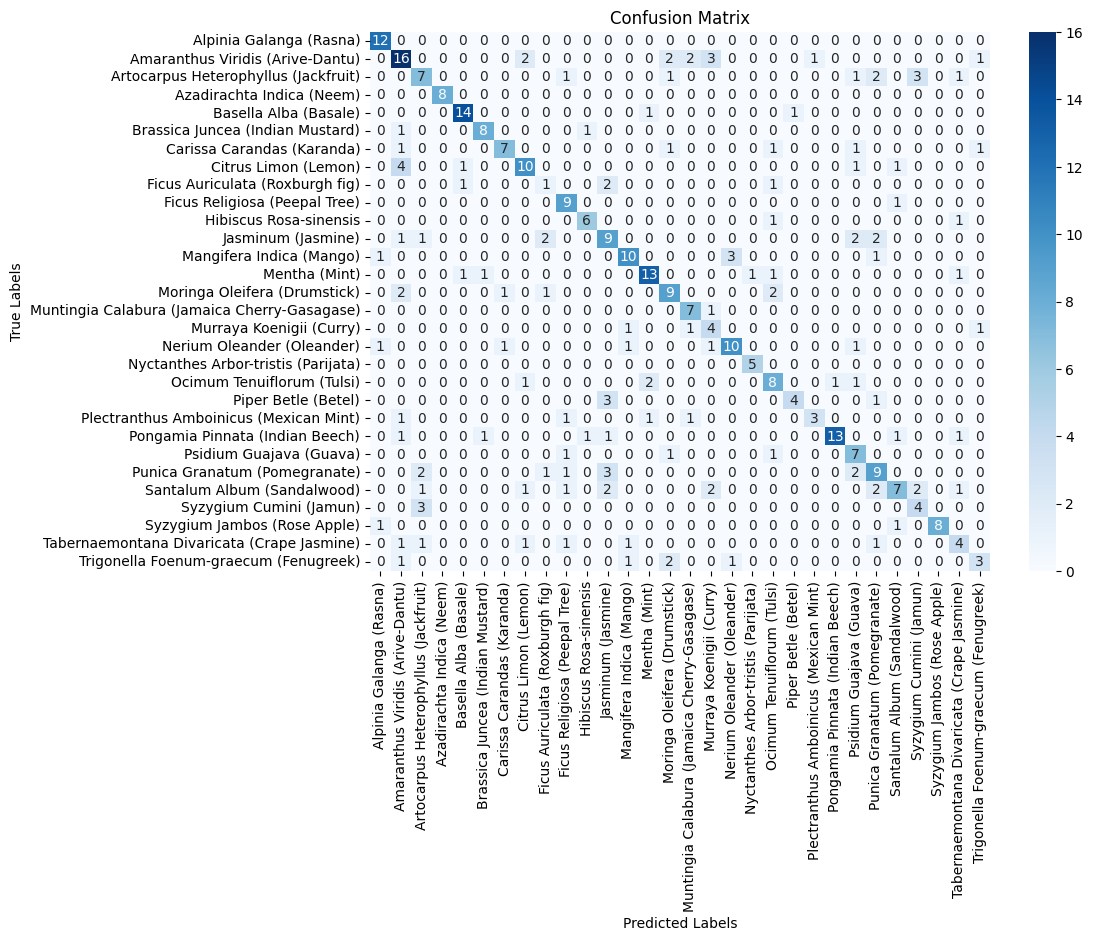

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
xg_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)
xg_model.fit(X_train, y_train)
y_pred = xg_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred, average='weighted')
recall_xgb = recall_score(y_test, y_pred, average='weighted')
f1_xgb = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy (XGBoost): {accuracy_xgb:.2f}")
print(f"Precision (Overall): {precision_xgb:.2f}")
print(f"Recall (Overall): {recall_xgb:.2f}")
print(f"F1-Score (Overall): {f1_xgb:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Original feature shape: (1846, 96)
Reduced feature shape: (1846, 68)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy (RandomForest): 0.53
Precision (Overall): 0.55
Recall (Overall): 0.53
F1-Score (Overall): 0.51
Confusion Matrix:


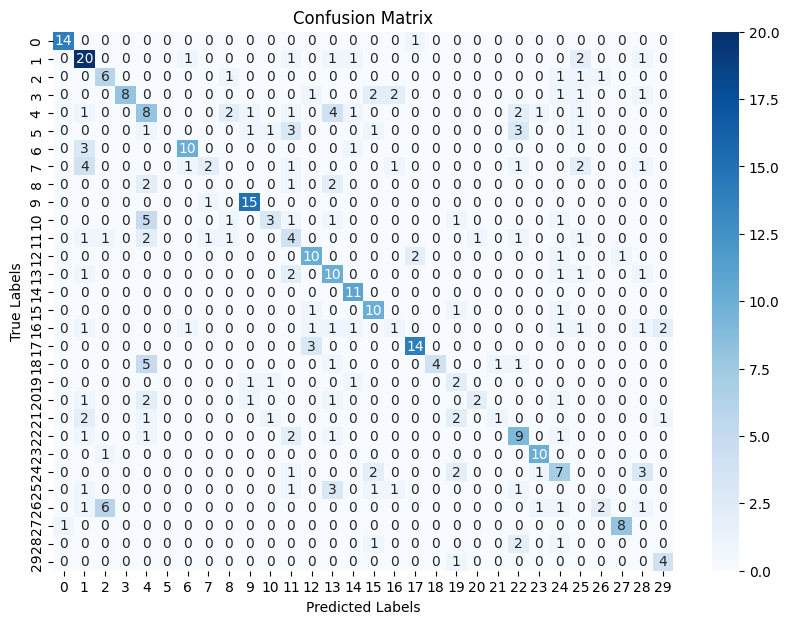

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=6):
    """
    Extract HOG features from an image with reduced complexity.
    """
    features = hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return features
def downsample_image(image, size=(64, 64)):
    return cv2.resize(image, size)
features, labels = [], []
for batch_images, batch_labels in df:
    for image, label in zip(batch_images, batch_labels):
        if isinstance(image, tf.Tensor):
            image_np = image.numpy().astype('uint8')
        else:
            image_np = image.astype('uint8')
        downsampled_image = downsample_image(image_np)
        grayscale_image = cv2.cvtColor(downsampled_image, cv2.COLOR_BGR2GRAY)
        hog_features = extract_hog_features(grayscale_image)
        features.append(hog_features)
        labels.append(label.numpy() if isinstance(label, tf.Tensor) else label)

features = np.array(features)
labels = np.array(labels)
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(normalized_features)

print(f"Original feature shape: {features.shape}")
print(f"Reduced feature shape: {pca_features.shape}")
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_features, labels, test_size=0.2, random_state=42
)
rf_model = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
rf_model.fit(train_features, train_labels)
predicted_labels = rf_model.predict(test_features)
accuracy_rf = accuracy_score(test_labels, predicted_labels)
precision_rf = precision_score(test_labels, predicted_labels, average='weighted')
recall_rf = recall_score(test_labels, predicted_labels, average='weighted')
f1_rf = f1_score(test_labels, predicted_labels, average='weighted')
print(f"Accuracy (RandomForest): {accuracy_rf:.2f}")
print(f"Precision (Overall): {precision_rf:.2f}")
print(f"Recall (Overall): {recall_rf:.2f}")
print(f"F1-Score (Overall): {f1_rf:.2f}")
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
